 # Diagnosing PCN with constraint

In [1]:
from types import SimpleNamespace
from functools import partial
import pydove as dv
import matplotlib as mpl
import matplotlib.pyplot as plt

import torch

from tqdm.notebook import tqdm

from cpcn import *

 ## Setup

In [2]:
device = torch.device("cpu")

# for reproducibility
torch.manual_seed(123)

# get train, validation, and test loaders for MNIST
batch_size = 100
dataset = load_mnist(n_validation=1000, batch_size=batch_size, device=device)

 ## Train PCN

In [3]:
n_batches = 3000
dims = [784, 5, 10]

z_it = 50
z_lr = 0.07
# rho = 0.015
# rho = 0.001875
rho = 0.0012

torch.manual_seed(123)

net = PCNetwork(
    dims,
    z_lr=z_lr,
    z_it=z_it,
    constrained=True,
    rho=rho,
    fast_optimizer=torch.optim.Adam,
    bias=False,
)
net = net.to(device)

trainer = Trainer(net, dataset["train"], dataset["validation"])
trainer.peek_validation(every=10)
trainer.set_classifier("linear")

trainer.set_optimizer(torch.optim.SGD, lr=0.02)
trainer.set_lr_factor("Q", 10)
# trainer.set_optimizer(torch.optim.Adam, lr=0.003)
# trainer.add_scheduler(partial(torch.optim.lr_scheduler.ExponentialLR, gamma=0.9))

if net.constrained:
    trainer.peek("weight", ["W", "Q"], every=10)
else:
    trainer.peek("weight", ["W"], every=10)
trainer.peek_sample("latent", ["z"])

trainer.peek_fast_dynamics("fast", ["z"], count=4)

results = trainer.run(n_batches=n_batches, progress=tqdm)

  0%|          | 0/3000 [00:00<?, ?it/s]

 ## Check convergence of latent variables

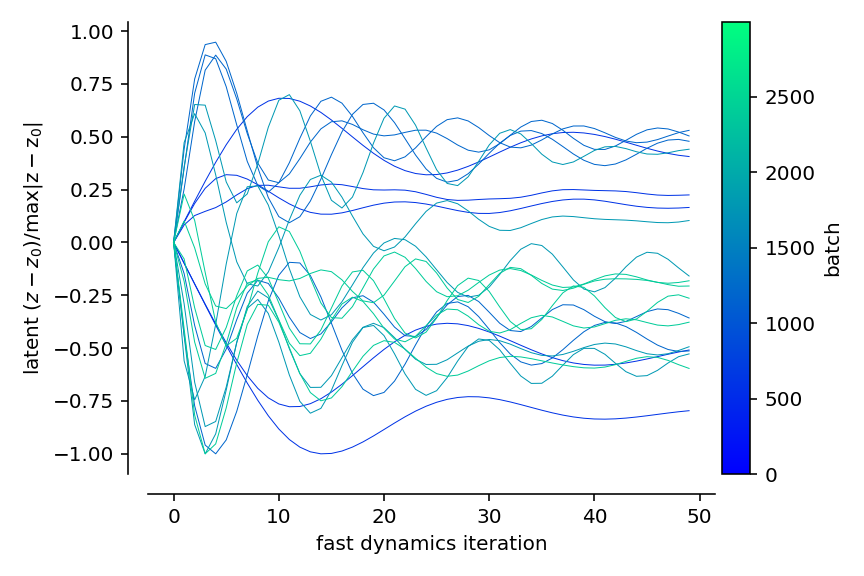

In [4]:
with dv.FigureManager() as (_, ax):
    show_latent_convergence(results.fast)

 ## Check whitening constraint in hidden layer

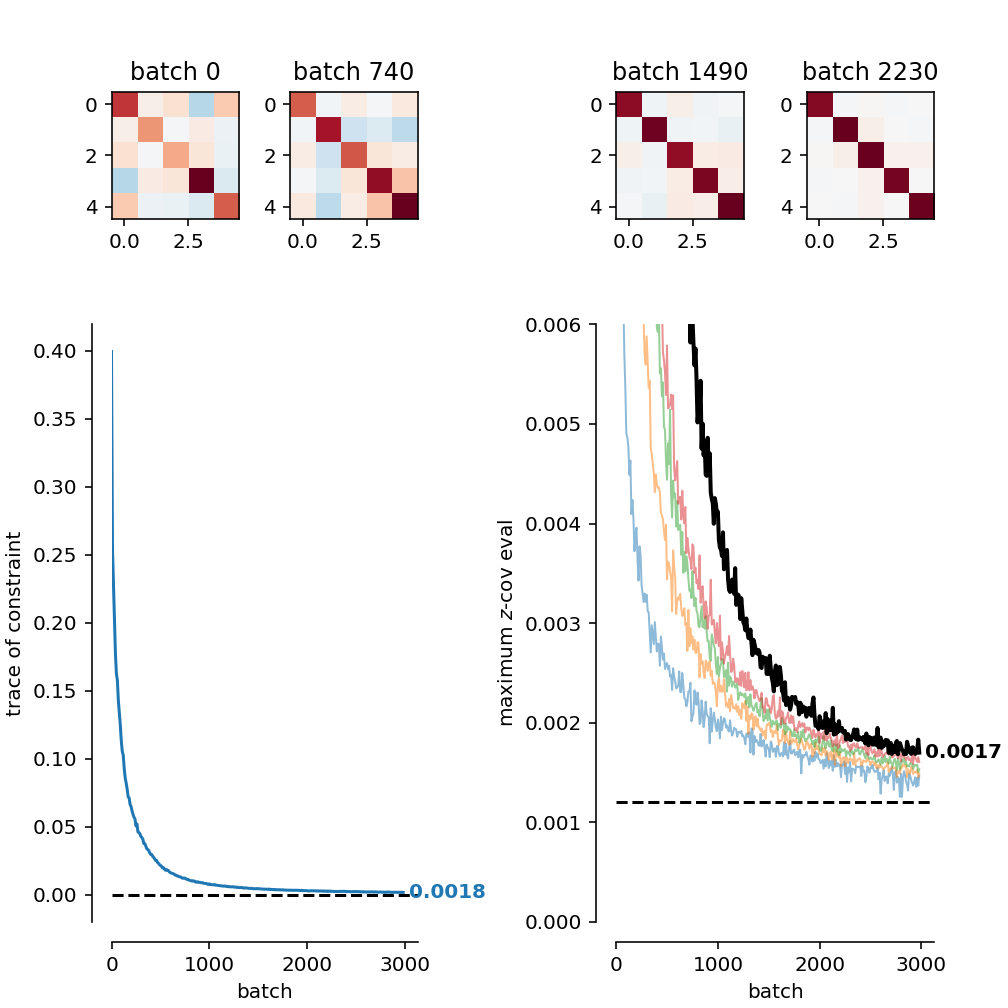

In [5]:
cons_diag = get_constraint_diagnostics(results.latent, rho=rho)
_ = show_constraint_diagnostics(cons_diag, rho=rho)

 ## Show loss and accuracy evolution

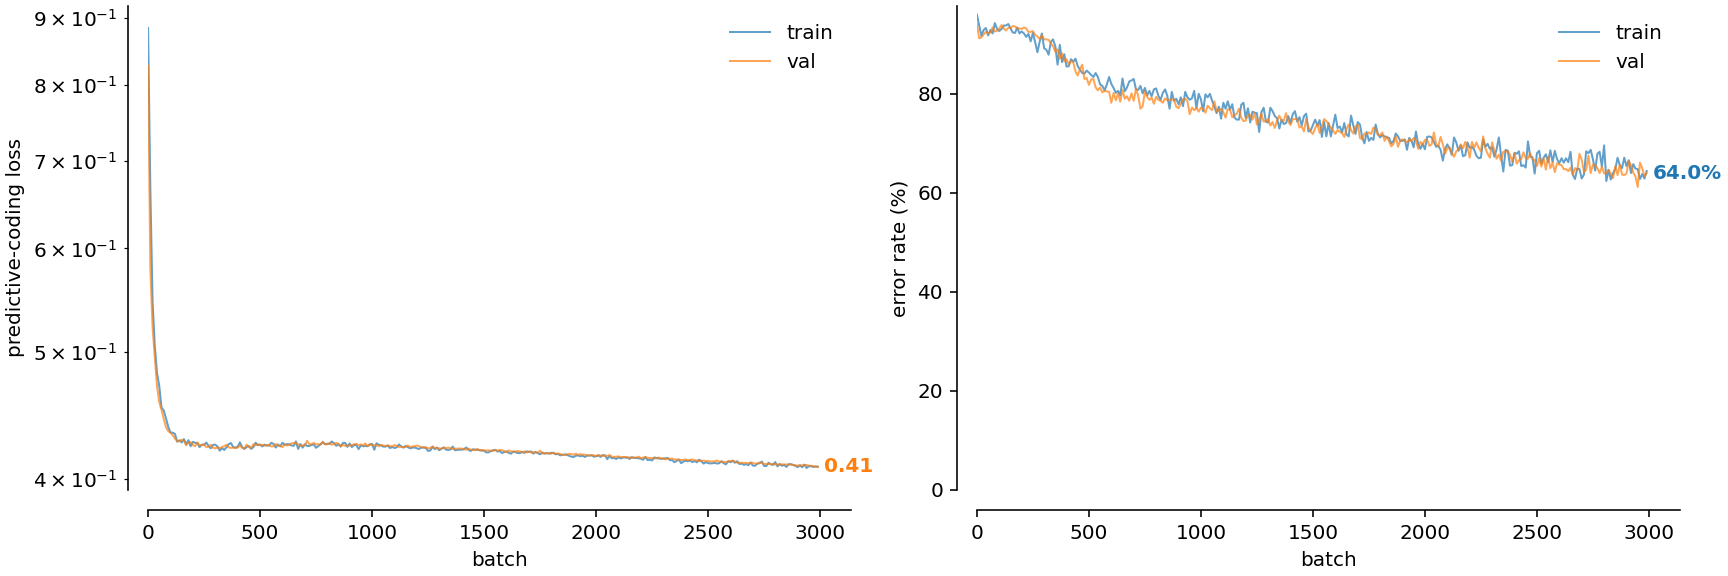

In [6]:
_ = show_learning_curves(results)

 ## Check weight evolution

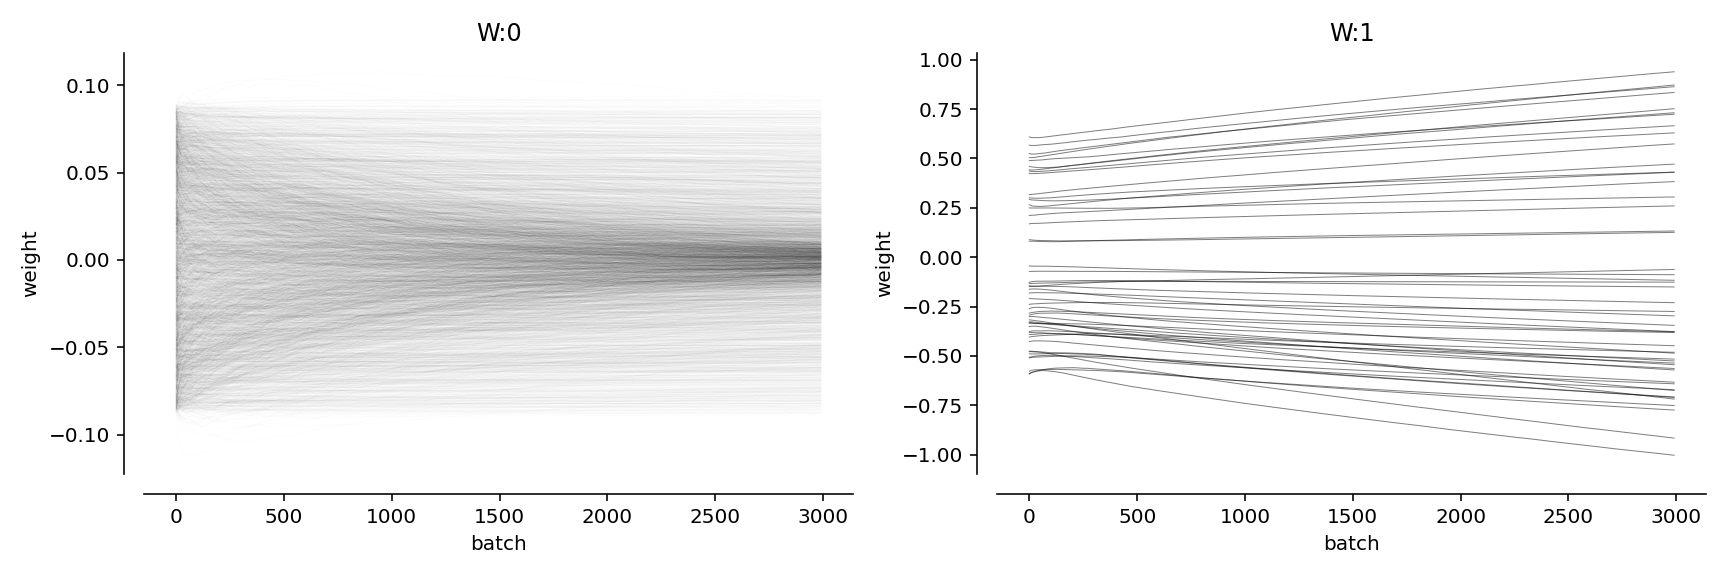

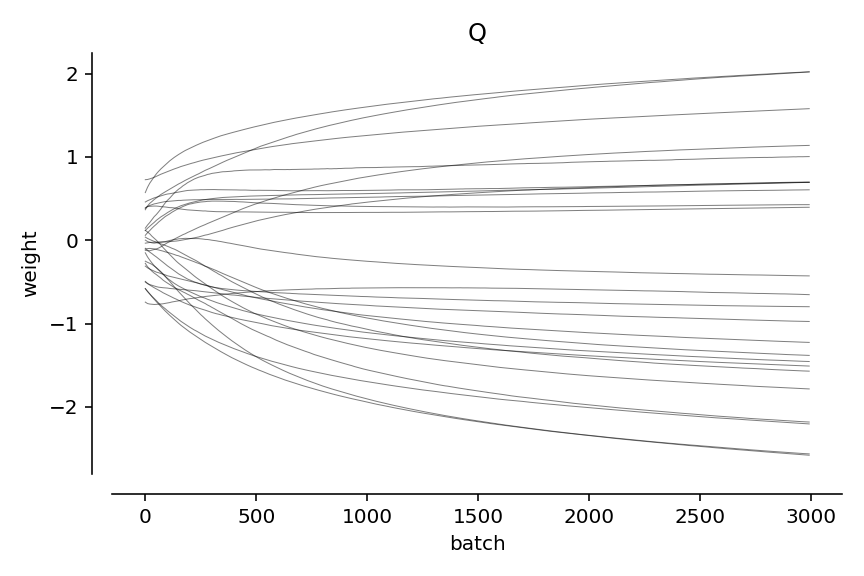

In [7]:
D = len(net.dims) - 1
with dv.FigureManager(1, D) as (_, axs):
    for k, ax in enumerate(axs):
        show_weight_evolution(results.weight["batch"], results.weight[f"W:{k}"], ax=ax)
        ax.set_title(f"W:{k}")

with dv.FigureManager() as (_, ax):
    show_weight_evolution(results.weight["batch"], results.weight["Q:0"], ax=ax)
    ax.set_title("Q")